In [17]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%matplotlib inline

In [18]:
"""
This notebook implements the Logistic Regression in the 
"Cutting the Metropolis Hastings Budget" framework. 

The target distribution is the posterior for a logistic regression
model trained on MNIST dataset for classifying digits 7 vs 9. The 
dataset consisted of 12007 datapoints. 
"""

# get input data

mat = scipy.io.loadmat('minist7vs1.mat')
TrainLabel = mat['TrainLabel']
TrainLabel = np.reshape(TrainLabel, TrainLabel.shape[1],1)
TrainImg = mat['TrainImg']
TestImg = mat['TestImg']
TestLabel = mat['TestLabel']
print TrainLabel.shape
print TrainImg.shape
print TrainImg[0].shape
TestLabel = np.reshape(TestLabel, TestLabel.shape[1],1)

(12007,)
(12007, 784)
(784,)


In [19]:
"""
Cutting the Metropolis Hastings Budget Method
"""
def random_walk_proposer(beta_t, sigmarw):
    """
    Input: beta_t  : previous parameters, 1-D array
           sigmarw : standard deviation, 1-D array
    """
    res = (np.random.multivariate_normal(beta_t, np.diag(sigmarw))).reshape((len(beta_t),))
    return res

def ll_data(beta_t, beta_n, X, Y):
    p_x_beta_t = 1/(1 + exp(-1* Y*np.dot(beta_t,X)))
    p_x_beta_n = 1/(1 + exp(-1* Y*np.dot(beta_n,X)))
    return log(p_x_beta_n) - log(p_x_beta_t)

def eval_U0(N):
    u = np.random.random()
    return 1/N*log(u)

def make_decision(l_list, N, U0):
    n = float(len(l_list))
    l_mean = sum(l_list)/n
    l_sq = ((np.array(l_list))**2).tolist()
    l_sq_mean = sum(l_sq)/n
    sl = sqrt((l_sq_mean - l_mean*l_mean)*n/(n-1))
    s = sl/sqrt(n) * sqrt(1 - (n-1)/(N-1))
    t_stats = abs((l_mean - U0)/s)
    delta = 1 - t.cdf(t_stats, n-1)
    return delta
    
def generate_parameter(beta_t, N, sigmarw, X, Y, batchsize, epsilon ):
    U0 = eval_U0(N)
    # generate new parameter
    P = len(X[0])
    sigma = (np.matlib.repmat(sigmarw, P,1)).reshape(P,)
    beta_n = random_walk_proposer(beta_t, sigma)
    
    # make decision
    l_list = []
    for i in range(batchsize):
        mid = ll_data(beta_t, beta_n, X[i], Y[i])
        l_list.append(mid)
    
    pos = batchsize
    delta = make_decision(l_list, N, U0)
    while (delta>epsilon) and (pos < N):
        mid = ll_data(beta_t, beta_n, X[pos], Y[pos])
        l_list.append(mid)
        pos = pos + 1
        delta = make_decision(l_list, N, U0)
    
    l_mean = sum(l_list)/float(len(l_list))
    if l_mean > U0:
        return (beta_n,1,pos)
    else:
        return (beta_t,0,pos)
    
def eval_cost(X,Y,beta):
    N = len(Y)
    cost = 0
    accuracy = 0
    for i in range(N):
        sigmoid_accuracy = 1/(1 + exp(-1* Y[i]*np.dot(beta,X[i])))
        if sigmoid_accuracy > 0.5 :
            accuracy = accuracy + 1
        sigmoid = -1.0 * np.log(1 + exp(-1 * Y[i] * np.dot(beta, X[i])))
        cost = cost + sigmoid
    return (cost/float(N), accuracy/float(N))
    
def train(X, Y, sigmarw, batchsize, epsilon, niter):
    N = len(Y) # number of total training data
    P = len(X[0]) # parameter dimension
    beta_t = np.zeros(P)
    cost_list = []
    accept_pos = []
    accuracy_list = []
    for i in range(niter):
        index = np.random.permutation(N)
        X = X[index]
        Y = Y[index]
        (beta_t, mid, pos) = generate_parameter(beta_t, N, sigmarw, X,Y,batchsize,epsilon)
        (cost,accuracy) = eval_cost(TestImg, TestLabel, beta_t)
        cost_list.append(cost)
        accuracy_list.append(accuracy)
        accept_pos.append(pos)
    return (cost_list, accept_pos, accuracy_list)

X = TrainImg
Y = TrainLabel
sigmarw = 0.01
batchsize = 10
epsilon = 0.02
niter = 500
(cost_list, accept_pos, accuracy) = train(X, Y, sigmarw, batchsize, epsilon, niter)

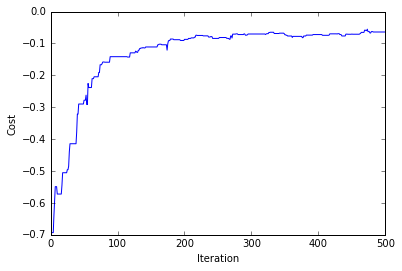

500
[27, 5699, 1249, 50, 2225, 14, 351, 157, 155, 73, 385, 28, 10, 57, 19, 44, 26, 55, 309, 30, 46, 373, 218, 412, 12, 1116, 17, 4386, 35, 175, 85, 31, 12, 3638, 1061, 63, 45, 10, 241, 24, 10, 11, 10, 95, 19, 35, 45, 296, 44, 21, 332, 30, 30, 484, 44, 325, 33, 12, 27, 14, 15, 214, 167, 34, 27, 57, 114, 88, 39, 10, 204, 41, 339, 272, 185, 23, 66, 237, 698, 255, 455, 526, 1060, 2415, 424, 5302, 285, 82, 1605, 624, 15, 35, 9182, 197, 190, 74, 281, 113, 68, 681, 67, 736, 156, 293, 5113, 2009, 76, 40, 16, 220, 1119, 138, 11266, 44, 100, 362, 233, 411, 643, 373, 2947, 43, 1524, 28, 544, 23, 74, 200, 725, 4638, 1320, 1809, 1278, 636, 281, 5634, 138, 316, 3492, 2007, 525, 1142, 10714, 51, 401, 140, 1185, 75, 191, 358, 66, 376, 825, 298, 538, 524, 279, 262, 2699, 979, 1624, 9464, 27, 209, 231, 406, 152, 319, 1354, 111, 106, 404, 506, 4336, 100, 375, 423, 577, 5935, 8681, 2145, 12, 353, 456, 10, 516, 856, 327, 724, 5969, 2123, 111, 1715, 211, 1079, 178, 338, 100, 67, 129, 11976, 643, 98, 3285, 2

In [20]:
plt.figure()
plt.plot(cost_list)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()
print len(cost_list)
print accept_pos

In [21]:
print sum(accept_pos)/float(len(accept_pos))

1876.268


500
500


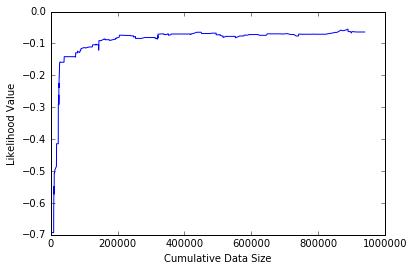

In [22]:
cumulate_datasize = [accept_pos[0]]
cumulate = accept_pos[0]
for i in range(1,len(accept_pos)):
    cumulate += accept_pos[i]
    cumulate_datasize.append(cumulate)

plt.figure()
print len(cumulate_datasize)
print len(cost_list)
plt.plot(cumulate_datasize, cost_list) 
plt.xlabel('Cumulative Data Size')
plt.ylabel('Likelihood Value')
plt.show()

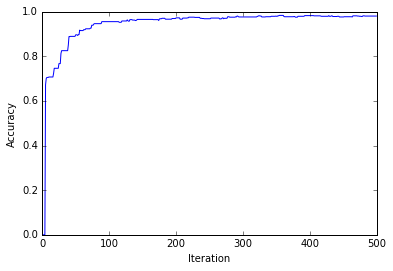

In [23]:
plt.figure()
plt.plot(accuracy)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()